## Оглавление 
1. [Введение](#step1)
2. [Обработка данных](#step2)
3. [Исследовательский анализ данных](#step3)
4. [Модель прогнозирования оттока пользователей](#step4)
5. [Кластеризация пользователей](#step5)
6. [Общий вывод](#step6)

## Введение<a id="step1"></a>

В качестве аналитика сети фитнес-центров «Культурист-датасаентист» нам необходимо разработать стратегию взаимодействия с пользователями на основе имеющихся о них данных. Наша задача — провести анализ этих данных и подготовить план действий по удержанию клиентов.

В нвшем распоряжении датасет со следующими полями:
- `Churn` — факт оттока в текущем месяце;
- `gender` — пол;
- `Near_Location` — проживание или работа в районе, где находится фитнес-центр;
- `Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
- `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- `Phone` — наличие контактного телефона;
- `Age` — возраст;
- `Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах);
- `Contract_period` — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год);
- `Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах);
- `Group_visits` — факт посещения групповых занятий;
- `Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;
- `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;
- `Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон.

Цели исследования:
- научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты пользователей: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
  сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
  - выделить целевые группы клиентов;
  - предложить меры по снижению оттока;
  - определить другие особенности взаимодействия с клиентами.

### Обработка данных<a id="step2"></a>

Загрузим необходимые библиотеки и методы.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans

Откроем наш датафрейм, сохранив его в переменной gym_data, и изучим содержащиеся внем данные.

In [2]:
gym_data = pd.read_csv('gym_churn.csv')

In [3]:
gym_data.head()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


Приведем названия колонок к нижнему регистру методом str.lower().

In [4]:
gym_data.columns = gym_data.columns.str.lower()

In [5]:
gym_data.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


In [6]:
gym_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   near_location                      4000 non-null   int64  
 2   partner                            4000 non-null   int64  
 3   promo_friends                      4000 non-null   int64  
 4   phone                              4000 non-null   int64  
 5   contract_period                    4000 non-null   int64  
 6   group_visits                       4000 non-null   int64  
 7   age                                4000 non-null   int64  
 8   avg_additional_charges_total       4000 non-null   float64
 9   month_to_end_contract              4000 non-null   float64
 10  lifetime                           4000 non-null   int64  
 11  avg_class_frequency_total          4000 non-null   float

Наш датафрейм содержит 4000 строк и 14 колонок. Целевой переменной в нашем исследовании являются данные в колонке `churn`. В колонках `contract_period`,  `age`, `avg_additional_charges_total`, `month_to_end_contract`,	`lifetime`, `avg_class_frequency_total`,	`avg_class_frequency_current_month` содержатся величины числовых признаков, а в колонках	  `gender`, `near_location`, `partner`, `promo_friends`, `phone`, `group_visits` - категориальных. Форматы данных во всех полях коректные и не требуют изменения. Данные не содержат значения Nan.

Проверим наш датафрейм на наличие дубликатов методом duplicated().

In [7]:
gym_data.duplicated().sum()

0

Дубликатов не обнаружено.

В целом, можно констатировать высокое качество данных, содержащихся в нашем датасете. В них нет пропусков и дубликатов, а форматы значений в полях датасета не требуют корректировки.

### Исследовательский анализ данных<a id="step3"></a>

Вызовем метод describe() для изучения распределения данных в полях для числовых признаков.

In [8]:
gym_data[['contract_period', 'age', 'avg_additional_charges_total', 
          'month_to_end_contract', 'avg_class_frequency_total', 
          'avg_class_frequency_current_month']].describe().round(2)

,contract_period,age,avg_additional_charges_total,month_to_end_contract,avg_class_frequency_total,avg_class_frequency_current_month
count,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00
mean,4.68,29.18,146.94,4.32,1.88,1.77
std,4.55,3.26,96.36,4.19,0.97,1.05
min,1.00,18.00,0.15,1.00,0.00,0.00
25%,1.00,27.00,68.87,1.00,1.18,0.96
50%,1.00,29.00,136.22,1.00,1.83,1.72
75%,6.00,31.00,210.95,6.00,2.54,2.51
max,12.00,41.00,552.59,12.00,6.02,6.15


У признаков contract_period и month_to_end_contract среднее значение существенно превышает медианное. Эти признаки имеют самое высокое значение стандартного отклонения (в относительных величинах).  У остальных признаков разброс данных не такой существенный.

Рассчитаем средние значения признаков в группе ех, кто ушел в отток, и тех, кто остался.

In [9]:
gym_data_churn = gym_data.groupby('churn').mean()
gym_data_churn

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


Наиболее существенно по группам различаются  средние значения признаков contract_period, lifetime и avg_additional_charges_total (они выше у группы оставшихся пользователей).

Изучим распределение величины каждого признака по группам, построив для этого гистограммы с помощью цикла.

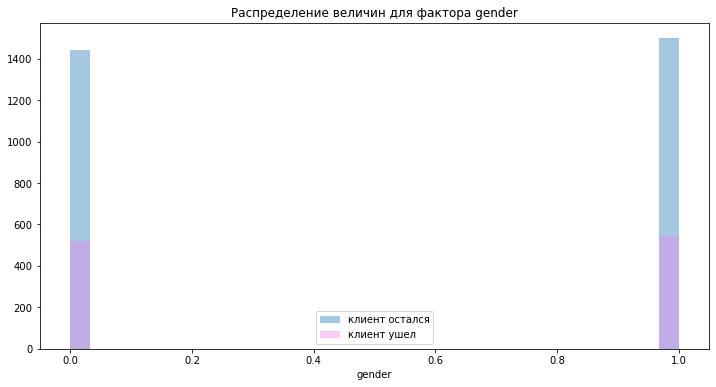

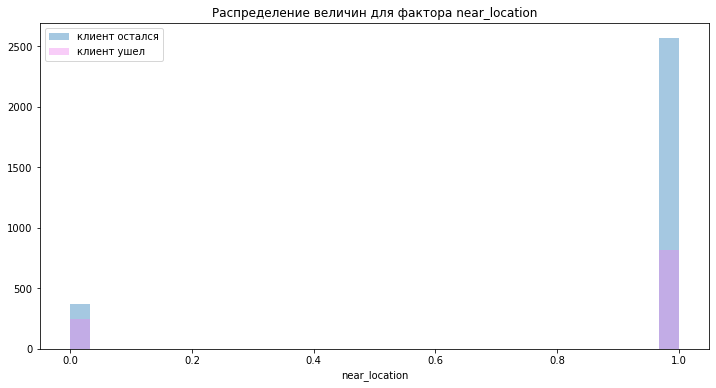

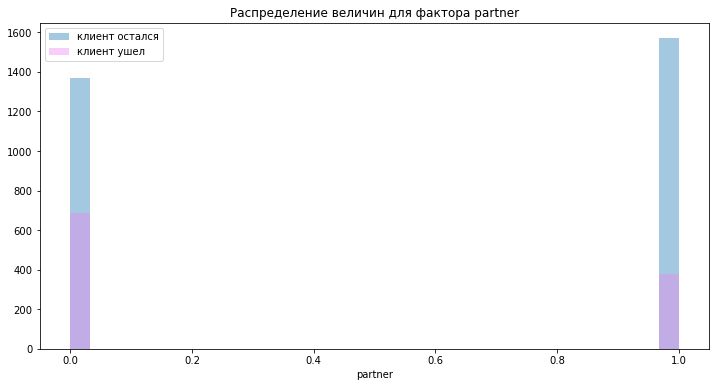

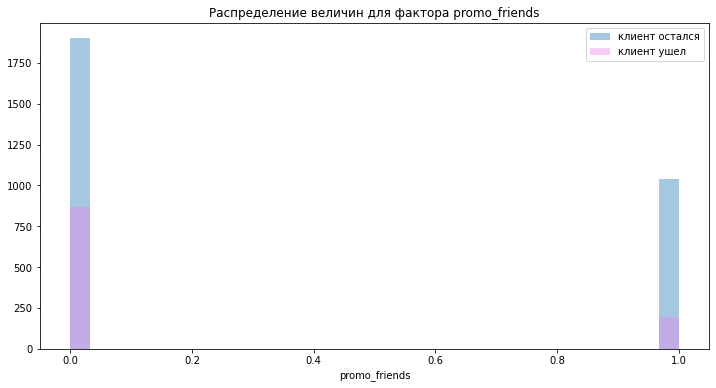

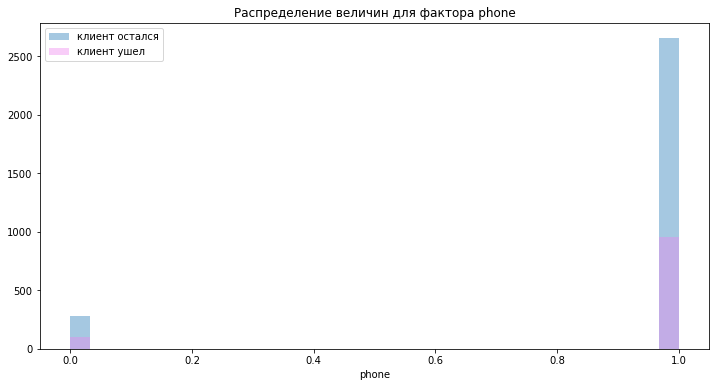

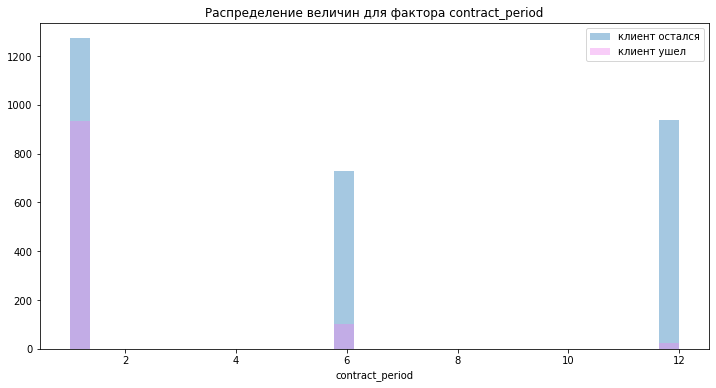

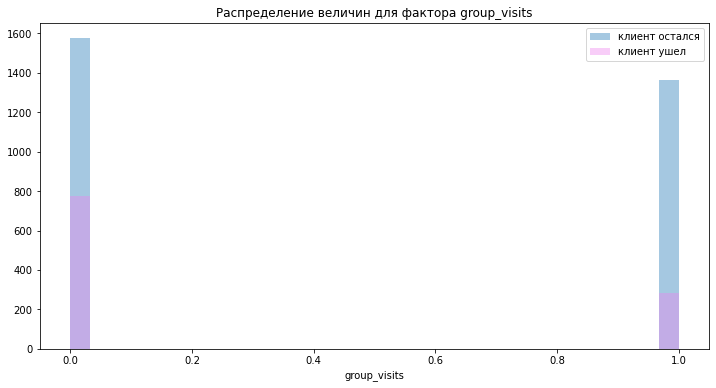

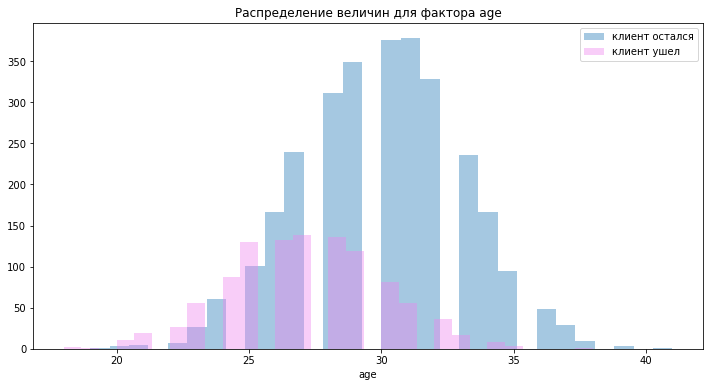

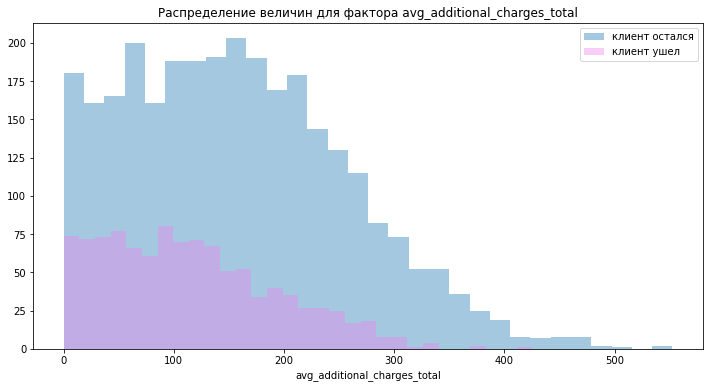

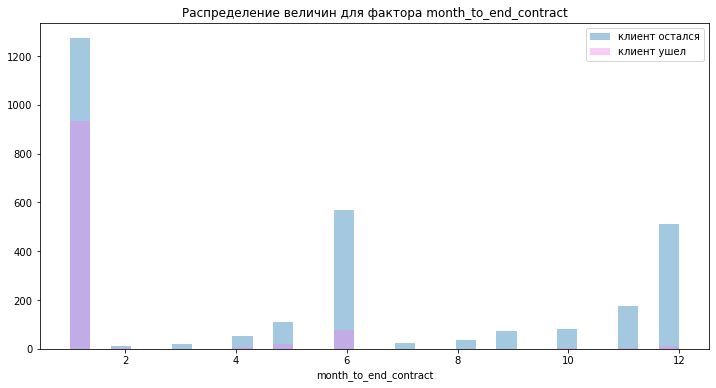

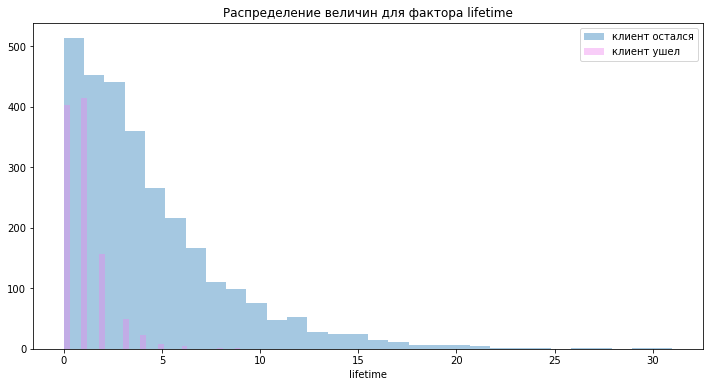

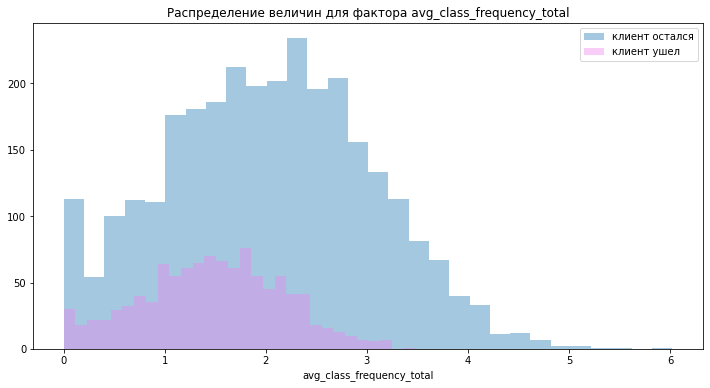

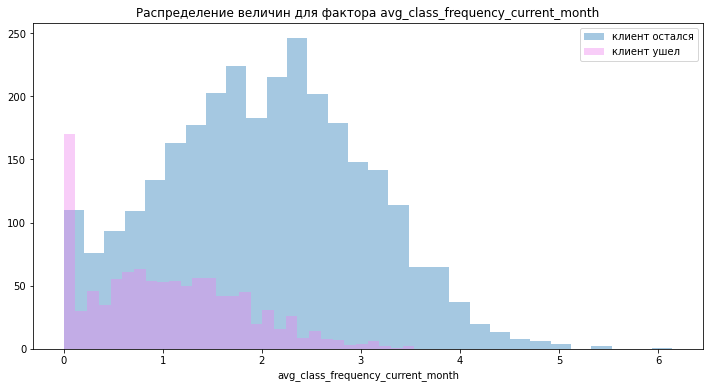

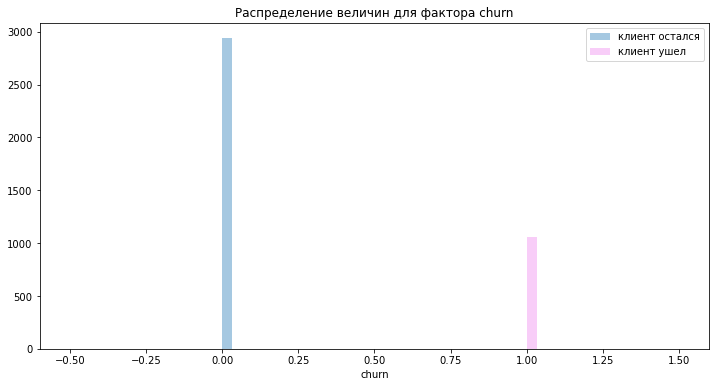

In [10]:
gym_data_stayed = gym_data.query('churn==0')
gym_data_left = gym_data.query('churn==1')
for column in gym_data.columns:
    plt.figure(figsize=(12,6))
    sns.distplot(gym_data_stayed[column], label='клиент остался', bins=30, kde=False)
    sns.distplot(gym_data_left[column], label='клиент ушел', color='violet', bins=30, kde=False)
    plt.title('Распределение величин для фактора {}'.format(column))
    plt.legend()
    plt.show()

Покинувших клуб в текущем месяце клиентов в три раза меньше оставшихся. В целом, кривые распределения величин факторов при обоих значениях `churn` похожи. Для факторов age, avg_class_frequency_current_month' и avg_class_frequency_total' криве распределения для ушедших пользователей распределены левее, а значит мы можем заключить, что фитнес-клубы покидает более молодая аудитория, что является для маркетологов компании определенным сигналом, указывающим на необходимрсть разработки эффективных механизмов удержания более молодых пользователей. Меньшие медианные значения факторов avg_class_frequency_current_month' и avg_class_frequency_total' легко объяснимы: пользователи, реже посещающие занятия, теряют либо потеряли интерес к тренировкам в наших клубах и со временем, прекращают членство в них либо не продлевают абонемент.   

Далее отразим на тепловаой карте корреляцию между факторам.

Text(0.5, 1.0, 'Тепловая карта матрицы корреляций между признаками')

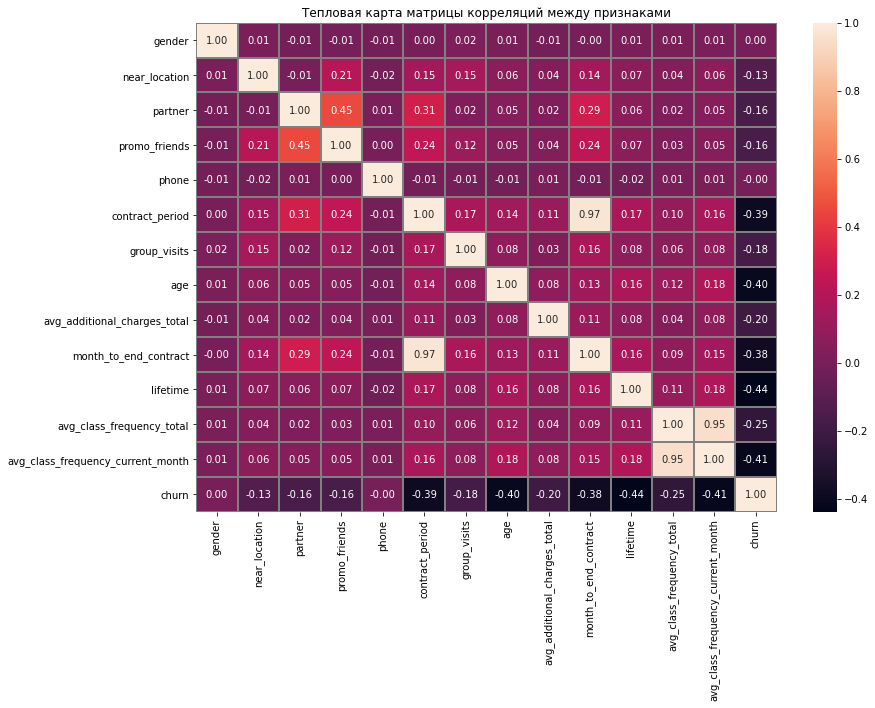

In [11]:
plt.figure(figsize=(13,9))
gym_data_corr = gym_data.corr()
sns.heatmap(gym_data_corr, annot=True, fmt='.2f', linewidths=1, linecolor='gray')
plt.title('Тепловая карта матрицы корреляций между признаками')

Здесь мы столкнулись с проблемой мультиколлениарности для пар признаков "month_to_end_contract - contract_period" и "average_class_frequency_total - average_class_frequency_current_month". Коэффициенты корреляции для этих пар близки к единице, а значит при дальнейшем обучении модели прогнозирования оттока пользователей они могут негативно сказаться на ее качестве.

### Модель прогнозирования оттока пользователей<a id="step4"></a>

Прежде чем приступить к построению модели, уберем из датасета поля `contract_period` и `avg_class_frequency_current_month` для устранения проблемы мультиколлениарности признаков.

In [12]:
gym_data = gym_data.drop(columns=['contract_period', 'avg_class_frequency_current_month'])

Сохраним в переменной X значения признаков, а в переменной y - значения целевой переменной.

In [13]:
X = gym_data.drop(columns=['churn'])
y = gym_data['churn']

Разделим выборку на тестовую и валидационную в соотношении 80/20 с помощью функции train_test_split().

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Применим метод StandartScaler() для стандартизации тестовых и валидационных признаков.

In [15]:
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

Обучим модель на train-выборке логистической регрессией LogisticRegression() и случайным лесом RandomForestClassifier(). Оценим метрики accuracy, precision и recall для обеих моделей на валидационной выборке и сравним по ним модели.

In [16]:
model = LogisticRegression(random_state=0)
model.fit(X_train_st, y_train)
predictions = model.predict(X_test_st)
probabilities = model.predict_proba(X_test_st)[:,1]
print('Метрики для модели логистической регрессии')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, predictions)))

Метрики для модели логистической регрессии
Accuracy: 0.90
Precision: 0.81
Recall: 0.79


In [17]:
rf_model = RandomForestClassifier(random_state=0, n_estimators=100)
rf_model.fit(X_train_st, y_train)
rf_predictions = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)[:,1]
print('Метрики для модели случайного леса')
print('Accuracy: {:.2f}'.format(accuracy_score(y_test, rf_predictions)))
print('Precision: {:.2f}'.format(precision_score(y_test, rf_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, rf_predictions)))

Метрики для модели случайного леса
Accuracy: 0.89
Precision: 0.82
Recall: 0.77


Модель логистической регрессии имеет приемущество по показателям метрик accuracy и recall. Выберем эту модель в качестве базовой для прогнозирования оттока пользователей.

Выведем модули коэффициентов признаков методом coef_ для оценки важности каждого признака. Создадим датафрейм gym_fata_coef с названиями признаков и их весами в модели и на его основе построим столбчатую диаграмму для наглядного отображения весов каждого признака.

In [18]:
[coef] = abs(model.coef_)
coef

array([0.00441092, 0.08278858, 0.06460814, 0.22195375, 0.10217351,
       0.39706652, 1.14684346, 0.61004174, 1.31981682, 3.6481989 ,
       0.69556633])

In [19]:
gym_fata_coef = pd.DataFrame({'Признаки':X.columns, 'Важность': coef})
gym_fata_coef = gym_fata_coef.sort_values(by='Важность', ascending=False)
gym_fata_coef

,Признаки,Важность
9,lifetime,3.648199
8,month_to_end_contract,1.319817
6,age,1.146843
10,avg_class_frequency_total,0.695566
7,avg_additional_charges_total,0.610042
5,group_visits,0.397067
3,promo_friends,0.221954
4,phone,0.102174
1,near_location,0.082789
2,partner,0.064608


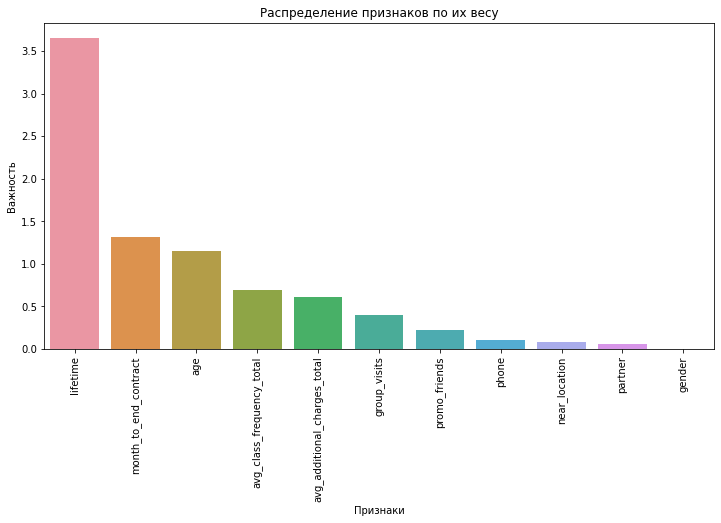

In [20]:
plt.figure(figsize=(12,6))
sns.barplot(x='Признаки', y='Важность', data=gym_fata_coef)
plt.title('Распределение признаков по их весу')
plt.xticks(rotation=90)
plt.show()

Наиболее весомым признаком в нашей модели является lifetime. Следующие по важности признаки -  month_to_end_contract, age и avg_class-frequency_total. Наименнее значимыми являются признаки near_location, gender и phone.

Выше мы уже писали о влиянии возраста на пользователей на их отток и необходимость разработки механизмов удержания более молодых пользователей. По результатам данного этапа исследования мы сможем дать маркетолоам практические рекомендации по снижению оттока пользователей на основе приоретизации всех признаков в нашей модели.

### Кластеризация пользователей<a id="step5"></a>

Далее проведем кластеризацию пользователей. Сначала стандартизируем величины всех признаков (переменная X). 

In [21]:
x_sc = scaler.fit_transform(X)
print(x_sc[:5])

[[ 0.97970588  0.42788074  1.02686062  1.49716101 -3.05985201  1.19403206
  -0.0565538  -1.37753121  0.16160501 -0.19332863 -1.91191971]
 [-1.0207145   0.42788074 -0.973842   -0.66793083  0.32681319  1.19403206
   0.55732732 -0.35021325  1.83194105  0.87368001  0.04517569]
 [-1.0207145   0.42788074  1.02686062 -0.66793083  0.32681319 -0.83749845
  -0.36349436 -0.1815923  -0.79287273 -0.46008079 -0.02049263]
 [-1.0207145   0.42788074  1.02686062  1.49716101  0.32681319  1.19403206
   1.17120844 -0.87472237  1.83194105 -0.46008079  1.36465509]
 [ 0.97970588  0.42788074  1.02686062  1.49716101  0.32681319 -0.83749845
  -0.97737548  0.5336998  -0.79287273 -0.19332863 -0.78707638]]


В переменной linked сохраним матрицу расстояний между признаками. На ее основе построим дендрограмму.

In [22]:
linked = linkage(x_sc, method = 'ward')

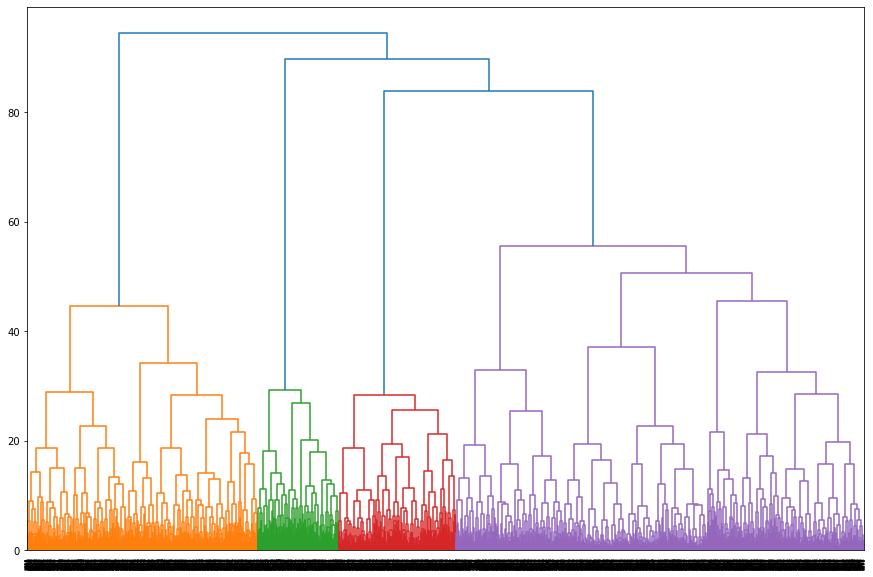

In [23]:
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.show()

Визуально на данной дендрограмме выделяются 4 кластера.

Далее обучим модель кластеризации на основании алгоритма K-Means и спрогнозируем кластеры клиентов. За число кластеров примем n=5

In [29]:
km = KMeans(n_clusters = 5)
labels = km.fit_predict(x_sc)

Сохраним вектор кластеров в переменной labels и его в датафрейм gym_data  во вновь созданном столбце `cluster_km`.

In [25]:
gym_data['cluster_km'] = labels

Сгруппируем gym_data по столбцу 'cluster_km' и рассчитаем средние значения признаков по кластерам.

In [26]:
gym_data.groupby(['cluster_km']).mean()

,gender,near_location,partner,promo_friends,phone,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,churn
cluster_km,,,,,,,,,,,,
0,0.523316,0.862694,0.471503,0.305699,0.0,0.427461,29.297927,144.208179,4.466321,3.940415,1.854211,0.266839
1,0.500898,0.000000,0.488330,0.077199,1.0,0.231598,28.685817,137.277472,2.804309,2.978456,1.762672,0.402154
2,0.496482,0.994975,0.896482,0.997990,1.0,0.519598,29.509548,151.550642,6.305528,4.178894,1.943892,0.133668
3,0.499552,1.000000,0.205909,0.055506,1.0,0.288272,27.712623,120.186679,1.930170,2.040286,1.518052,0.520143
4,0.537566,0.995767,0.392593,0.019048,1.0,0.546032,30.828571,180.535019,5.899471,5.589418,2.316094,0.021164


Построим гистограммы для отображения величин распределения факторов по кластерам.

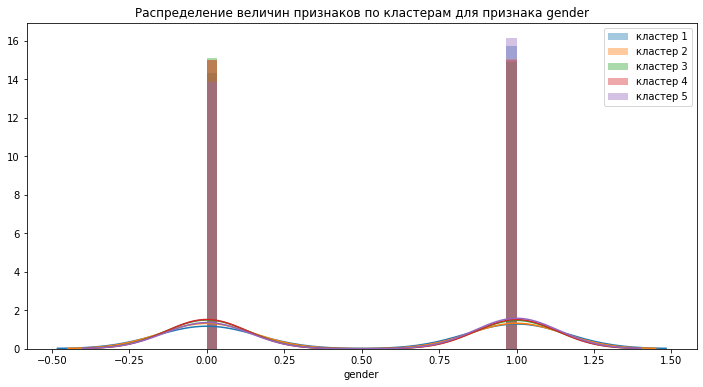

/Users/Aram/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/Users/Aram/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/Users/Aram/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/Users/Aram/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/Users/Aram/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


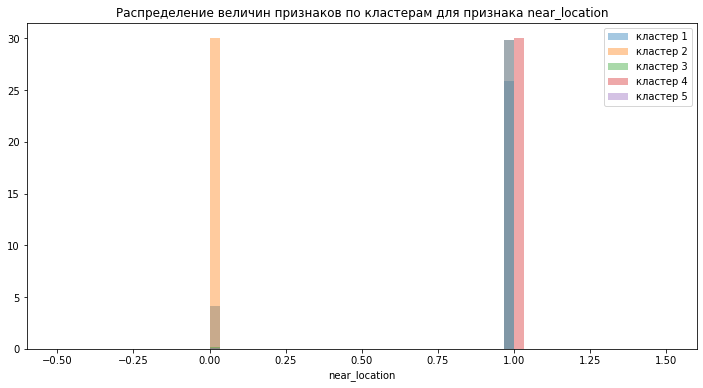

/Users/Aram/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/Users/Aram/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


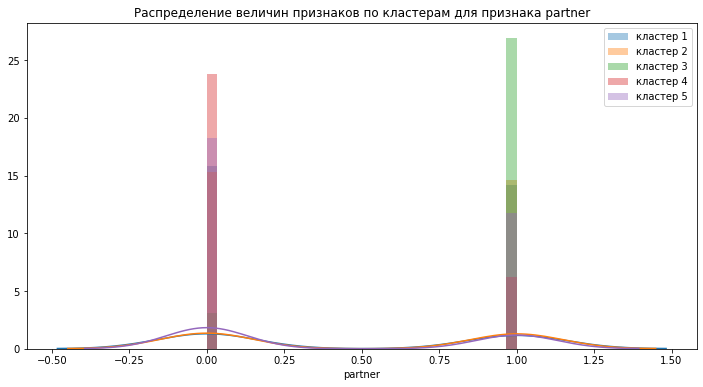

/Users/Aram/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/Users/Aram/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/Users/Aram/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/Users/Aram/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


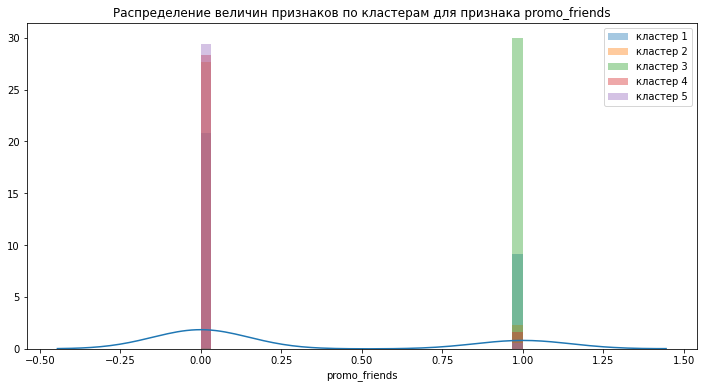

/Users/Aram/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/Users/Aram/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/Users/Aram/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/Users/Aram/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
/Users/Aram/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


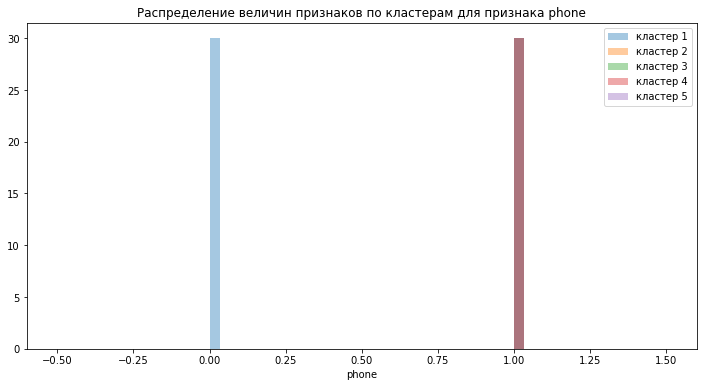

/Users/Aram/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


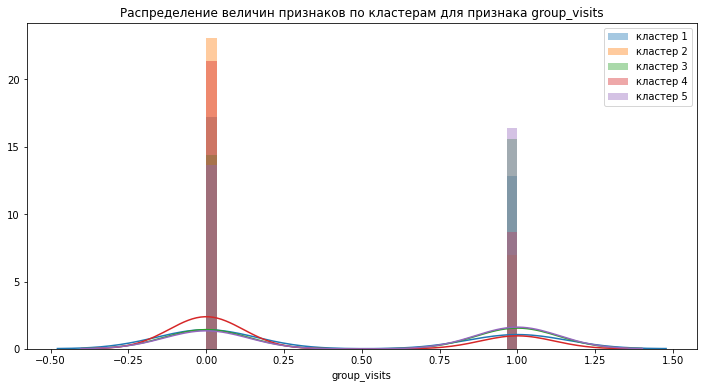

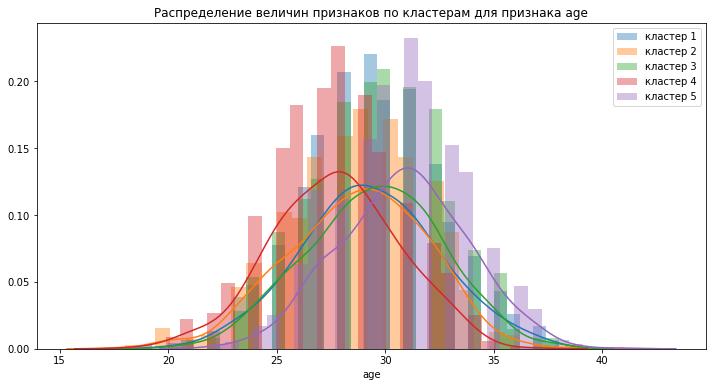

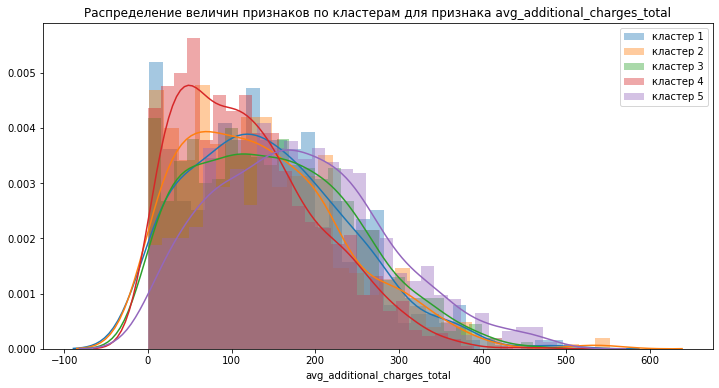

/Users/Aram/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


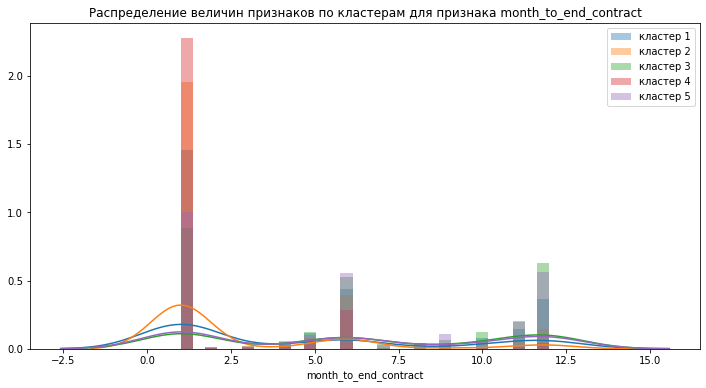

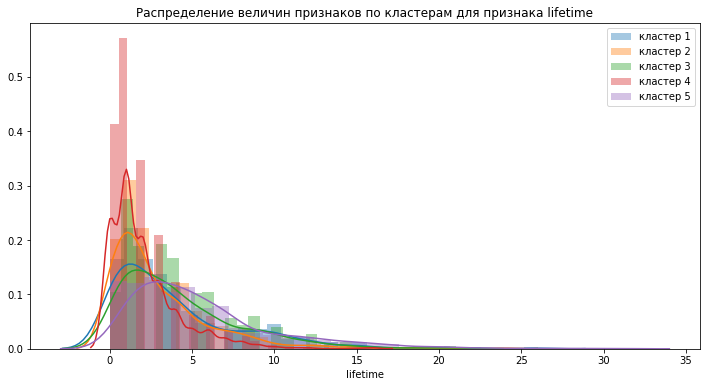

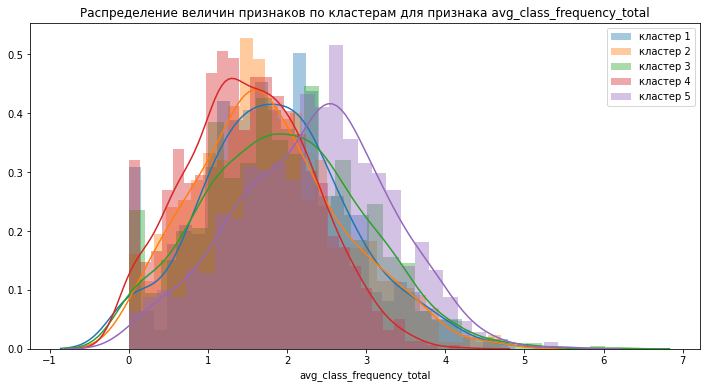

/Users/Aram/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
/Users/Aram/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


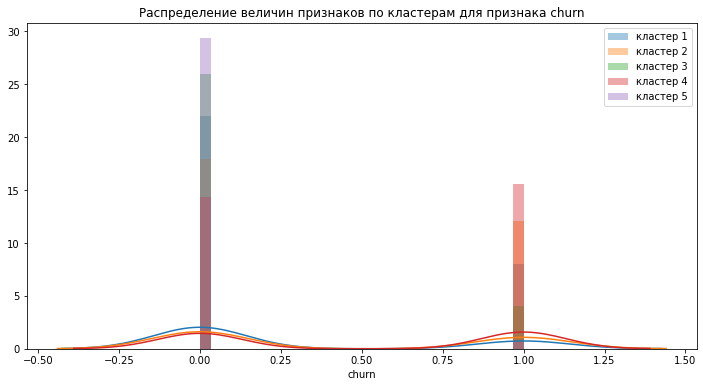

In [27]:
cluster_km_0 = gym_data.query('cluster_km == 0')
cluster_km_1 = gym_data.query('cluster_km == 1')
cluster_km_2 = gym_data.query('cluster_km == 2')
cluster_km_3 = gym_data.query('cluster_km == 3')
cluster_km_4 = gym_data.query('cluster_km == 4')
for column in gym_data.columns:
    if column != 'cluster_km':
        plt.figure(figsize=(12,6))
        sns.distplot(cluster_km_0[column], label='кластер 1', bins=30)
        sns.distplot(cluster_km_1[column], label='кластер 2', bins=30)
        sns.distplot(cluster_km_2[column], label='кластер 3', bins=30)
        sns.distplot(cluster_km_3[column], label='кластер 4', bins=30)
        sns.distplot(cluster_km_4[column], label='кластер 5', bins=30)
        plt.title('Распределение величин признаков по кластерам для признака {}'.format(column))
        plt.legend()
        plt.show()

Обращает на себя внимание кластер 4: он значительно отличается по распределению значений признаков phone, avg_additional_charge_total, lifetime и avg_class_frequency_total. Также примечательно, что в кластер 1 попали все пользоватеи, не указавшие свои номера телефона.

Выясним, как кластеры отличаются друг от друга по доле оттока пользователей.

In [28]:
gym_data.groupby('cluster_km')['churn'].value_counts(normalize=True)

cluster_km  churn
0           0        0.733161
            1        0.266839
1           0        0.597846
            1        0.402154
2           0        0.866332
            1        0.133668
3           1        0.520143
            0        0.479857
4           0        0.978836
            1        0.021164
Name: churn, dtype: float64

Наиболее высока доля оттока для первого и второго кластеров (73% и 74% соответственно). У пятого кластера доля оттока совсем незначительна - около 1%. Также невысока доля оттока у третьего кластера - 13%.

## Общий вывод<a id="step6"></a>

- Наш датафрейм содержит 4000 строк и 14 колонок. Целевой переменной в нашем исследовании являются данные в колонке `churn`. В колонках `contract_period`,  `age`, `avg_additional_charges_total`, `month_to_end_contract`,	`lifetime`, `avg_class_frequency_total`,	`avg_class_frequency_current_month` содержатся величины числовых признаков, а в колонках	  `gender`, `near_location`, `partner`, `promo_friends`, `phone`, `group_visits` - категориальных. Можно констатировать высокое качество данных, содержащихся в датасете. В них нет пропусков и дубликатов, а форматы значений в полях датасета не требуют корректировки;
- у признаков contract_period и month_to_end_contract среднее значение существенно превышает медианное. Эти признаки имеют самое высокое значение стандартного отклонения (в относительных величинах). У остальных признаков разброс данных не такой существенный;
- наиболее существенно по группам оставшихся и ушедших в отток пользователей различаются средние значения признаков contract_period, lifetime и avg_additional_charges_total (они выше у группы оставшихся пользователей);
- покинувших клуб в текущем месяце клиентов в три раза меньше оставшихся. В целом, кривые распределения величин факторов при обоих значениях churn похожи. Для факторов age, avg_class_frequency_current_month' и avg_class_frequency_total' кривые распределения для ушедших пользователей распределены левее. Можно констатировать отток более иолодых пользователей и тех, кто редко посещал групповые занатия;
- мы столкнулись с проблемой мультиколлениарности для пар признаков "month_to_end_contract - contract_period" и "average_class_frequency_total - average_class_frequency_current_month". Коэффициенты корреляции для этих пар близки к единице. Перед построением модели прогнозирования оттока пользователей поля `contract_period` и `avg_class_frequency_current_month` были исключены из датафрейма gym_data;
- модель была обучена на train-выборке логистической регрессией LogisticRegression() и случайным лесом. В качестве оценки моделей были применены метрики accuracy, precision и recall;
- модель логистической регрессии имеет приемущество по показателям метрик accuracy и recall и была выбрана в качестве базовой для прогнозирования оттока пользователей;
- наиболее весомым признаком в нашей модели является lifetime. Следующие по важности признаки - month_to_end_contract, age и avg_class-frequency_total. Наименнее значимыми являются признаки near_location, gender и phone;
- при построении дендрограммы визуально было выявлено четыре кластера;
- модель также была обучена кластеризации на основании алгоритма K-Means с числом кластеров равным 5;
- среди всех кластеров выделяется кластер 1: он значительно отличается по распределению значений признаков phone, avg_additional_charge_total, lifetime и avg_class_frequency_total. Также примечательно, что в кластер 4 попали все пользоватеи, не указавшие свои номера телефона;
- наиболее высока доля оттока пользователей для первого и второго кластеров (73% и 74% соответственно). У пятого кластера доля оттока совсем незначительна - около 1%. Также невысока доля оттока у третьего кластера - 13%.

Рекомендации маркетологам и менеджменту компании:
- разработать особую программу лояльности для тех пользователей, которые дольше остальных являются клиентами нашей сети;
- разработать эффективные механизмы стимулирования пользователей с истекающими абонементами для их продления;
- уделить больше  внимания более молодой аудитории, придумать для нее особые меры стимулирования. В качестве такой меры могут быть, например дополнительные скидки школьникам и студентам;
- обратить внимание на количество и качество групповых тренировок. Разнообразить их новыми видами тренировок, а также привлечь квалифицированных тренеров с новыми идеями и творческим подходом к тренировочному процессу.